# <font color = 'blue'> __Opinion Dynamics Markov Model__

### TOC: 
- [Binary Converters, Transition Matrix](#TM)
- [Rankings of Most Likely States to be Reactive](#RStateRanking)
- [Total Plots](#TotalPlots)
- [Conditional Probability I](#CPI)
- [Conditional Probability II](#CPII)

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [18]:
# Initialising the graph
edge_list = nx.florentine_families_graph()#[(0,1), (1,2), (1,3), (2,3)]
#edge_list = [(0,1), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5), (3,4), (3,5), (4,5)] + [(0,6), (6, 7), (6,8), (7,8)]

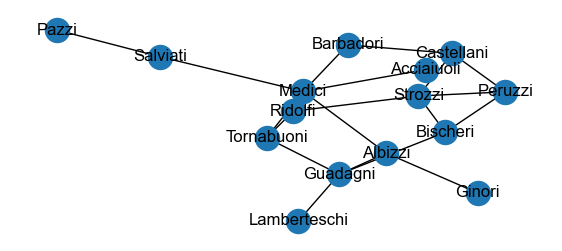

In [4]:
#G = nx.from_edgelist(edge_list)
G = nx.florentine_families_graph() #nx.from_edgelist(edge_list) nx.florentine_families_graph(
size = len(G)
states = 2 ** size

# Graph
fig, ax = plt.subplots(figsize=(7,3))
nx.draw_spring(G, with_labels=True, ax=ax)
plt.axis("off")
plt.show()

## <a id='TM'> <font color = 'blue'> __Binary Converters__ </a>
In this section, we note that any graph state (in the sense of opinions) can be expressed as a binary number. However, indices in the transition matrix are in base 10. Hence, we introduce functions to convert base 10 digits into binary and vice versa, and an algorithm to compute the transition matrix of the graph states based on the structure of the graph.

In [6]:
def base10_to_binary(digit, display_length): # Self explanatory. Parameter n refers to the display length of the binary number
    binary = np.array([False] * display_length)
    
    quotient = digit # Initialise the objects that 
    remainder = 0
    counter = -1
    
    while quotient > 0:
        quotient, remainder = np.divmod(quotient, 2)
        if remainder == 1:
            binary[counter] = True
        counter -= 1
        
    return binary

def binary_to_base10(binary, display_length): # Self explanatory. Parameter n refers to the display length of the binary number 
    b10_number = 0
    for i in range(display_length):
        b10_number += binary[-i - 1] * (2 ** i)
    return b10_number

def one_digit_difference(binary): # Finds all the binary numbers that are different in one digit to a given binary number 
    size = len(binary)
    neighbours = []
    
    for i in range(-1, -size - 1, -1):
        new_neighbour = binary.copy()
        new_neighbour[i] = ~(binary[i])
        neighbours.append(new_neighbour)

    return neighbours

In [8]:
def TM_graph(G, p=0.5): # Computes the transition matrix for the states. Here states refers to the possible states of the graph. 
    size = len(G)
    states = 2 ** size
    transition_matrix = np.zeros((states, states))

    neighbours = {i:list(G.neighbors(i)) for i in G.nodes()}

    for i in range(states): # Going through each row in the transition matrix 
        i_binary = base10_to_binary(i, size) # Current state
        possible_states = one_digit_difference(i_binary) # Computes a list of all the possible states from the current state
        
        for state in possible_states:
            flipped_node = np.argmax( np.flip(state != i_binary) ) 
            #print(state, neighbours[flipped_node])
            # Count how many neighbours of a node chosen to flip have different opinions
            num_diff_op_nb = ((np.flip(i_binary)[neighbours[flipped_node]]) != (np.flip(i_binary)[flipped_node])).sum() 
            if num_diff_op_nb == 0:
                switch_prob = 0 
            else:
                switch_prob = (1 - p) * (1 / num_diff_op_nb) 
            transition_matrix[i, binary_to_base10(state, size)] = (1 / size) * (p + switch_prob)
        
        transition_matrix[i, i] = 1 - transition_matrix[i].sum()
            
    return transition_matrix   
P = TM_graph(G, 0.2)

KeyError: 0

In [90]:
from tpt_gc import P_reverse, fcomm, bcomm, rd_calc, crd_calc
from tpt_gc import prob_curr_calc
# Initial distribution
pi_0 = np.ones(states) * (1/states)
A = [binary_to_base10(np.array([0,0,0,1,1,1,1,1,0]),size)]
B = [2 ** size - 1]
N = 25

P_reverse, distributions = P_reverse(P, pi_0, N) # Reverse process and distributions
q_plus, q_minus = fcomm(P, N, A, B), bcomm(P_reverse, N, A, B)
reactive_distributions = rd_calc(distributions, q_plus, q_minus)
prob_current = prob_curr_calc(q_plus, q_minus, distributions, P)
cond_reactive_distributions = crd_calc(reactive_distributions)

ImportError: cannot import name 'P_reverse' from 'tpt_gc' (C:\Users\trund\URSS\tpt_gc.py)

## <a id='RStateRanking'> <font color = 'blue'> __Rankings of Most Likely States to be Reactive__ </a>
In this section, we compute:
1. Given a time $n$, the states with the top $K$ reactive probability conditioned on being in the state, i.e.
\begin{equation}
\text{arg} \max_{i \in S} \rho^{A \to B}_i (n).
\end{equation}

2. The states with the top $K$ highest $\displaystyle  \rho^{A \to B}_i (n)$ over all $n \in [0, N]$ and all $i \in S$.

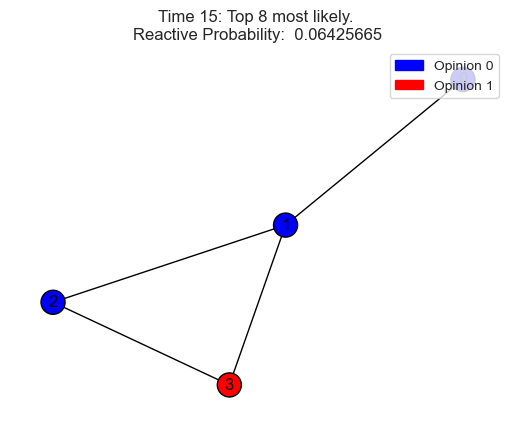

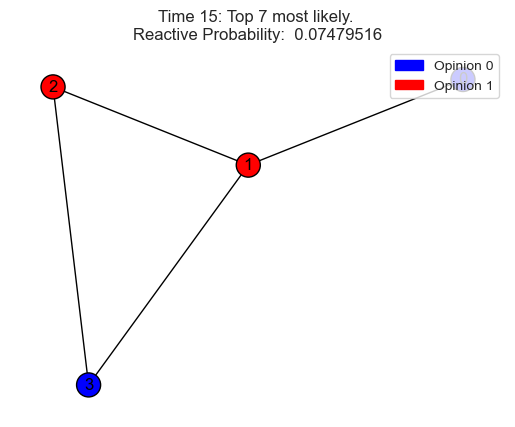

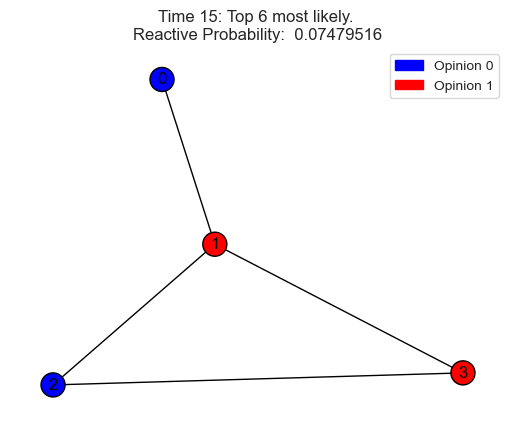

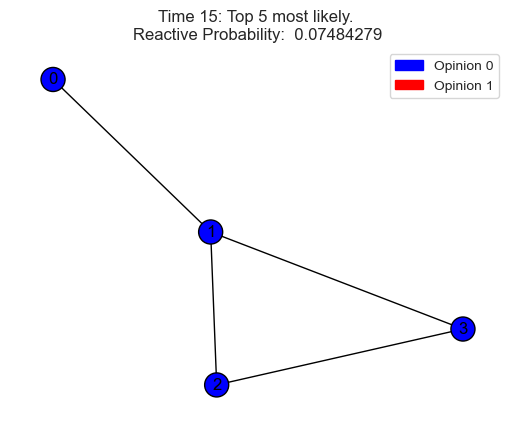

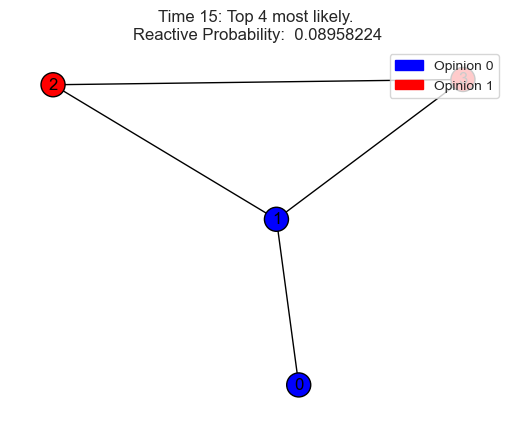

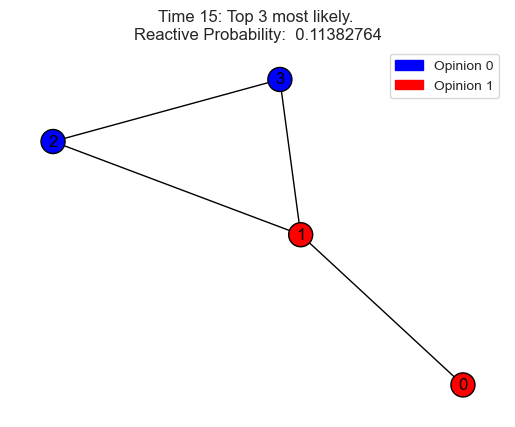

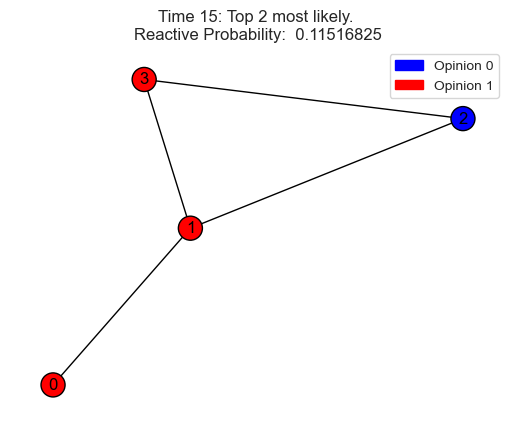

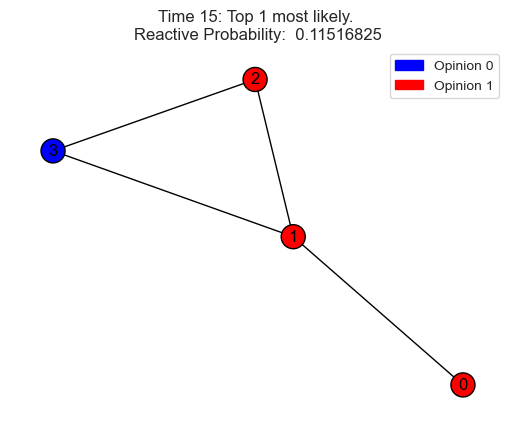

In [45]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def draw_topK_distributions(cond_reactive_distributions, time, K):
    topK_states = np.argsort(cond_reactive_distributions[time])[-K:]
    
    for k in range(-K, 0):
        state = base10_to_binary(topK_states[k], size) 
        reactive_prob = cond_reactive_distributions[time, topK_states[k]]
        pos = nx.spring_layout(G)
        labels = {i:i for i in G.nodes()}

        nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=np.flip(state), cmap= mcolors.ListedColormap(['blue', 'red']), 
                                       vmin=0, vmax=1, 
                                       edgecolors='black')
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, labels=labels)
        #plt.colorbar(labels)
        legend_elements = [mpatches.Patch(color='blue', label='Opinion 0'), mpatches.Patch(color='red', label='Opinion 1')]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.axis("off")
        plt.title(f'Time {time}: Top {-k} most likely. \nReactive Probability: {reactive_prob: .8f}')
        plt.show()

draw_topK_distributions(cond_reactive_distributions, 15, 8)

In [48]:
def dynamical_bn(cond_reactive_distributions, n_states=1):
    
    max_times, max_states = np.divmod(np.argsort(cond_reactive_distributions.flatten())[-n_states:], N)
    pos = nx.spring_layout(G)
    labels = {i:i for i in G.nodes()}

    for i in range(-n_states, 0):
        time = max_times[i]
        state = max_states[i]
        
        reactive_prob = cond_reactive_distributions[time, state]
        node_colors = np.flip(base10_to_binary(state, size))
        nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=np.flip(node_colors), cmap= mcolors.ListedColormap(['blue', 'red']), 
                                       vmin=0, vmax=1, 
                                       edgecolors='black')
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, labels=labels)
        #plt.colorbar(labels)
        legend_elements = [mpatches.Patch(color='blue', label='Opinion 0'), mpatches.Patch(color='red', label='Opinion 1')]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.axis('off')
        plt.title(f'Highest reactive probability ranking {-i}, reactive probability value:{reactive_prob: .6f} at time {time}')
        plt.show()

    return
    
dynamical_bn(cond_reactive_distributions, 3)

IndexError: index 20 is out of bounds for axis 1 with size 16

In [196]:
"""
# Visualistion three: finding out the best plots for 

def draw_reactive_distributions(T, A, B, reactive_distributions, prob_current, n_states):
    size = len(prob_current)

    for t in range(T):
        G = nx.from_numpy_array(prob_current[t], create_using=nx.DiGraph)
        pos = nx.spring_layout(G)

        nodes_to_draw = list(np.argsort(reactive_distributions[t])[-n_states:])
        edges_to_draw = []
        edge_widths = []

        labels = {i:i for i in nodes_to_draw}
        
        for u, v in G.edges():
            if u in nodes_to_draw and v in nodes_to_draw:
                edges_to_draw.append((u,v))
                edge_widths.append(prob_current[t, u, v] * 500)

        vmax, vmin= np.max(reactive_distributions), np.min(reactive_distributions)
        nodes = nx.draw_networkx_nodes(G, pos, nodelist=nodes_to_draw, node_color=reactive_distributions[t, nodes_to_draw], cmap=plt.cm.coolwarm,
                                       edgecolors='black', vmax=vmax, vmin=vmin)
        edges = nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, edge_color='black', connectionstyle= 'arc3,rad=0.3', width=edge_widths)
        print(nodes_to_draw)
        labels = nx.draw_networkx_labels(G, pos, labels=labels)

        plt.colorbar(nodes)
        plt.axis("off")
        plt.title(f'Reaction mechanism between top "{n_states}" most probable states at time {t}')
        plt.show()

        
draw_reactive_distributions(N, A, B, reactive_distributions, prob_current, 7)
"""

print("Archived")

Archived


## <a id ='TotalPlots'> <font color = 'blue'> __Total Plots__ </a>

In this section we shall make plots of the following:
1. The sum of the reactive probabilities at each time, i.e.
$$ \mathbb{P}(n \in R_N) = \sum_{i \in S}\mathbb{P}(n \in R_N, X_n = i) = \sum_{i \in S} \mu_i(n)$$
2. Sum of Probability over each state (i.e. which state
$$ \sum_{n \in [0, N]}\mathbb{P}(n \in R_N, X_n = i)$$

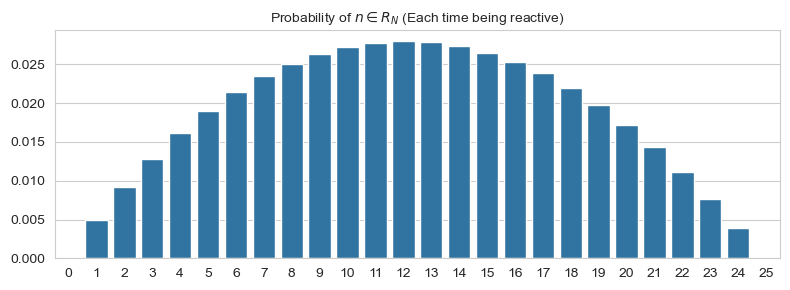

In [50]:
prob_n_reactive = np.sum(reactive_distributions, axis=1)

def barplot_reactive_time():
    fig, ax = plt.subplots(figsize=(8,3))
    sns.barplot(prob_n_reactive)
    ax.set_title(r'Probability of $n  \in R_N $ (Each time being reactive)', fontsize=10)
    fig.tight_layout()
    plt.show()
                
    return

barplot_reactive_time()

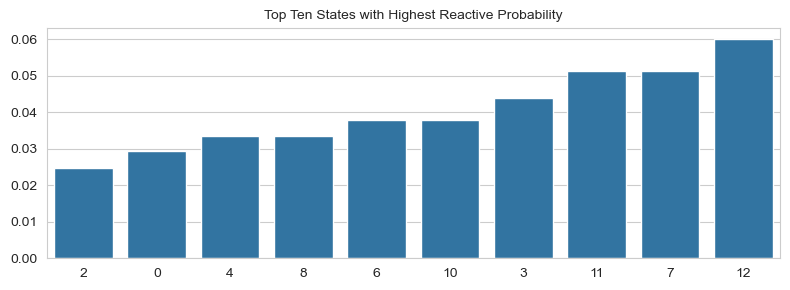

In [52]:
prob_state_reactive = np.sum(reactive_distributions, axis=0)

prob_state_reactive_top10 = np.sort(prob_state_reactive)[-10:] # Sorting is done in ascending order
top10_args = np.argsort(prob_state_reactive)[-10:] # Retrieves the arguments of the top 10 states
top10_args_labels = [f'{i}' for i in top10_args]

def barplot_top10_args():
    fig, ax = plt.subplots(figsize=(8,3))
    sns.barplot(y=prob_state_reactive_top10, x=top10_args_labels)
    ax.set_title(r'Top Ten States with Highest Reactive Probability', fontsize=10)
    fig.tight_layout()
    plt.show()

barplot_top10_args()

In [54]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def visualise_graph_state(state, size, G):
    binary_state = base10_to_binary(state, size) # Obtain the color-coded representation 

    pos = nx.spring_layout(G)
    labels = {i:i for i in G.nodes()}

    nodes = nx.draw_networkx_nodes(G, pos, node_color=np.flip(binary_state), cmap= mcolors.ListedColormap(['blue', 'red']), 
                                       vmin=0, vmax=1, edgecolors='black')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    legend_elements = [mpatches.Patch(color='blue', label='Opinion 0'), mpatches.Patch(color='red', label='Opinion 1')]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.axis("off")
    return

def visualise_top10_reactive_states():
    k = 0
    for i in top10_args:
        visualise_graph_state(i, size, G)
        plt.title(f'Most likely to be reactive states: Rank {10 - k}')
        plt.show()
        k += 1

    return
#visualise_top10_reactive_states()

## <a id ='CPI'> <font color = 'blue'> __Conditional Probability I__ </a>
Here we aim to compute:
$$\mathbb{P} (n \in R_N \, | \, X_n = i)$$
i.e. given that we are at a current state, what's the probability that we are reactive. This can be expressed using the committors:
$$\mathbb{P} (n \in R_N \, | \, X_n = i) = \psi_i^+(n) \cdot \psi_i^-(n) $$


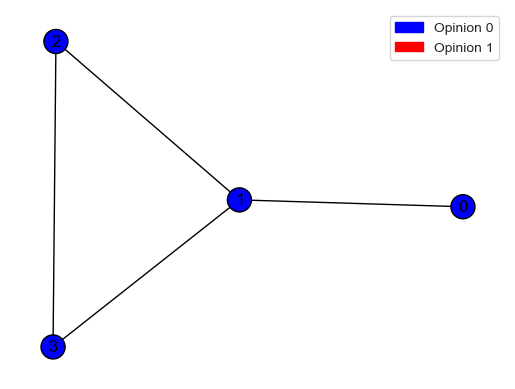

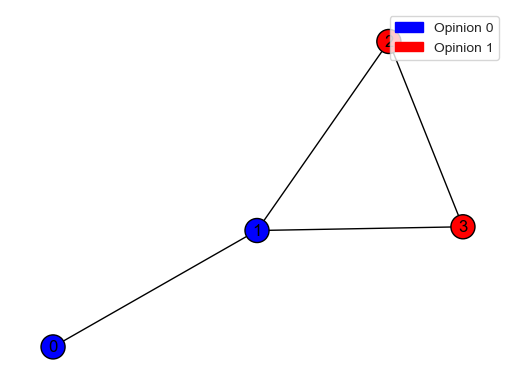

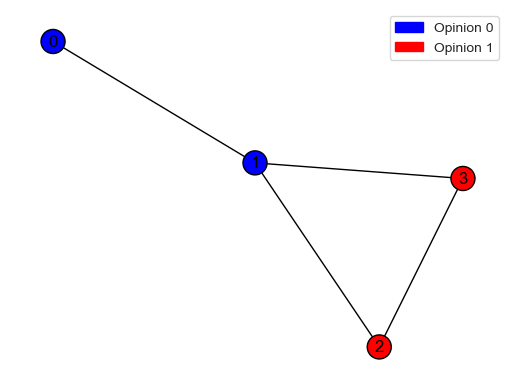

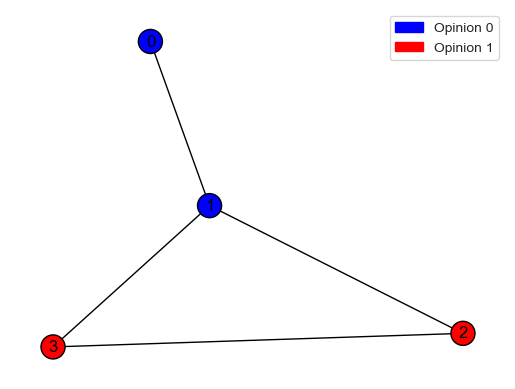

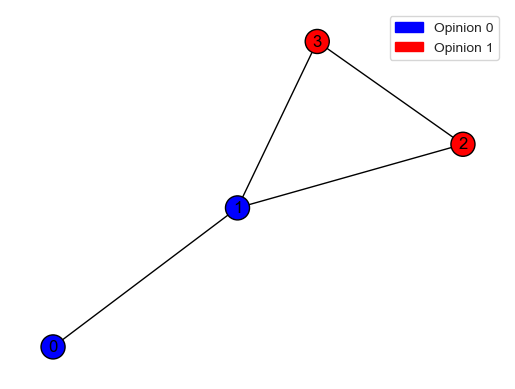

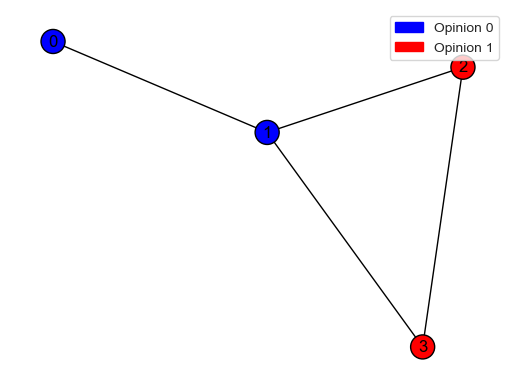

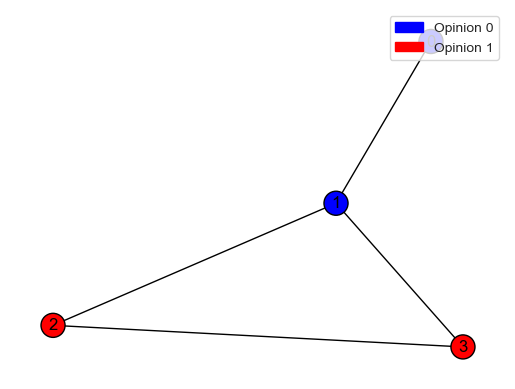

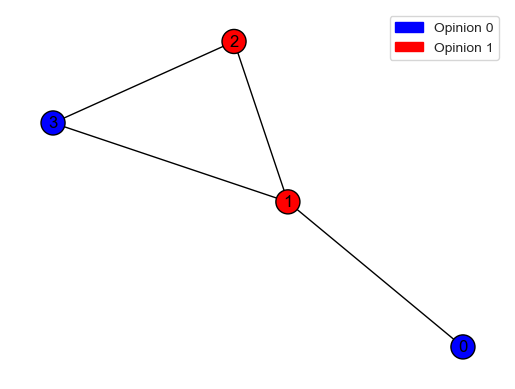

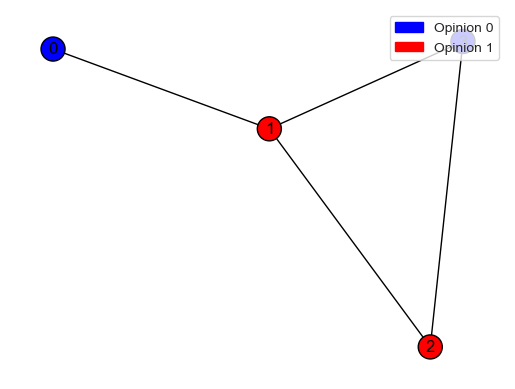

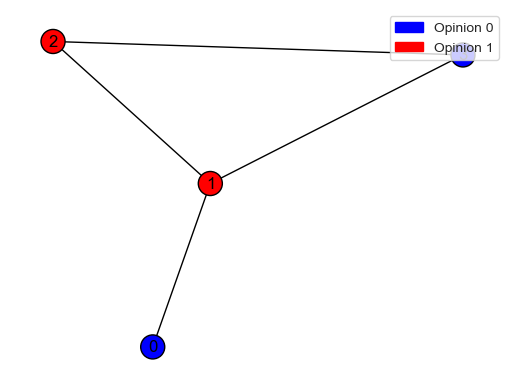

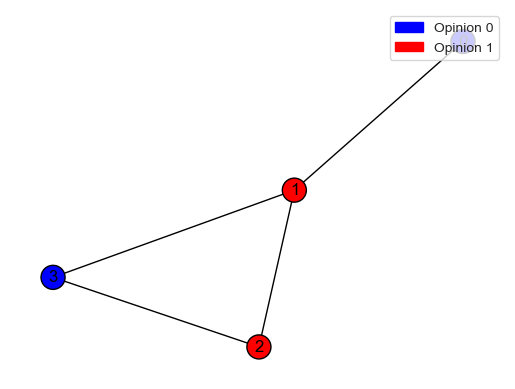

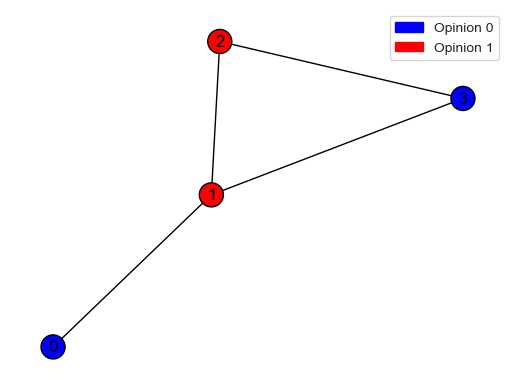

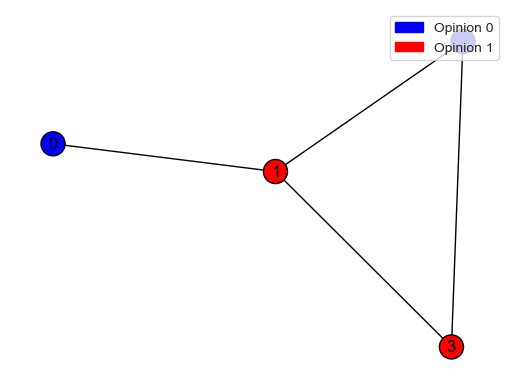

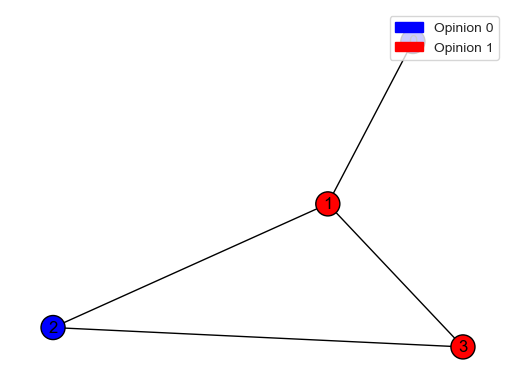

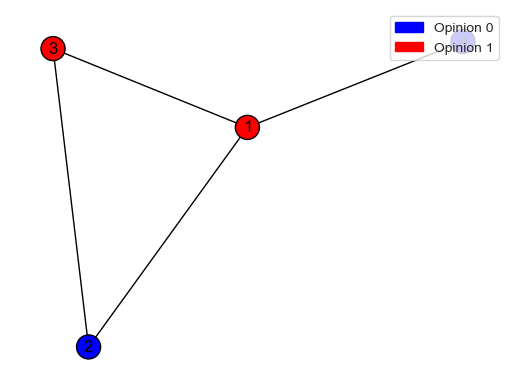

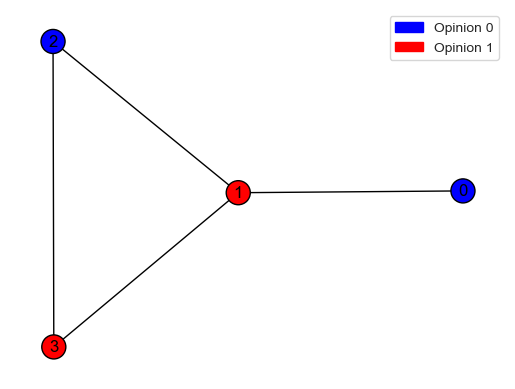

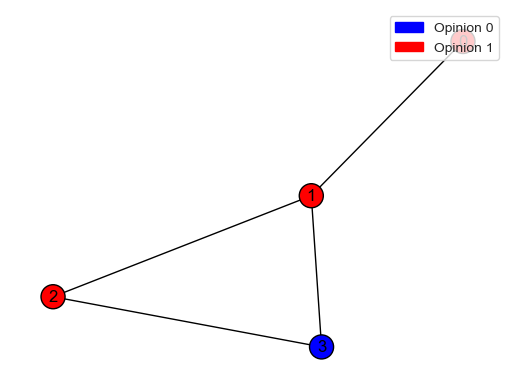

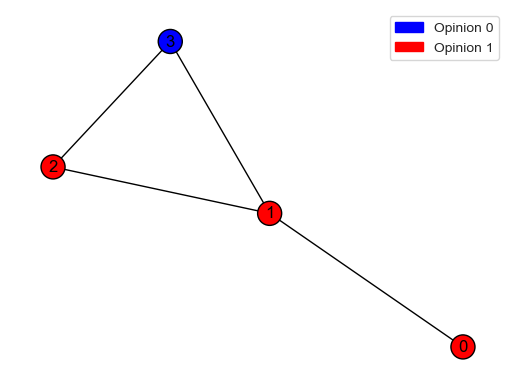

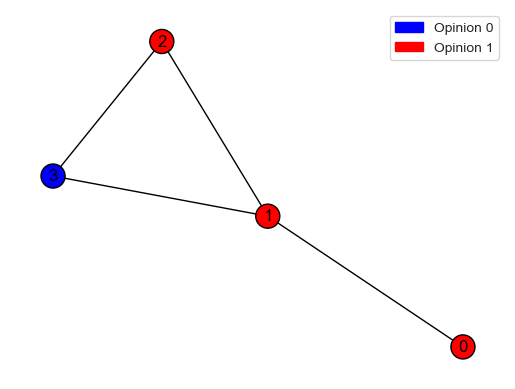

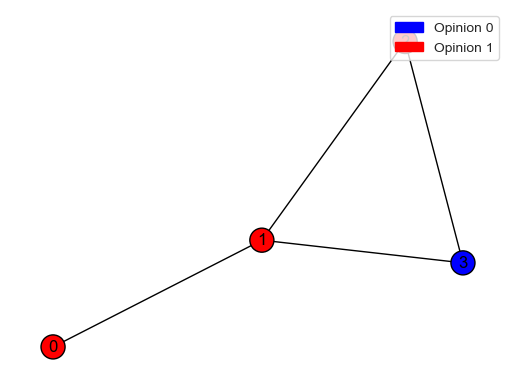

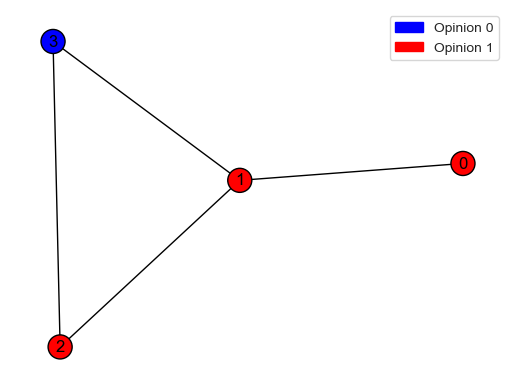

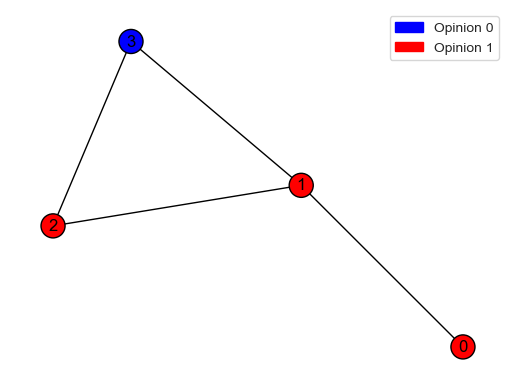

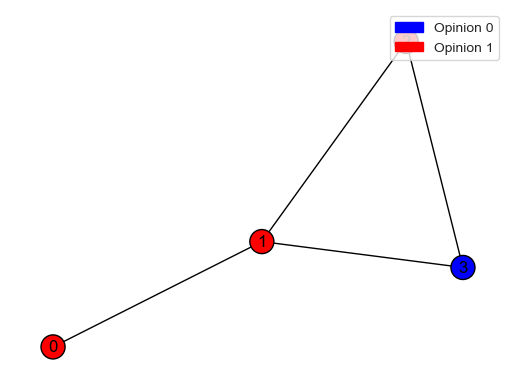

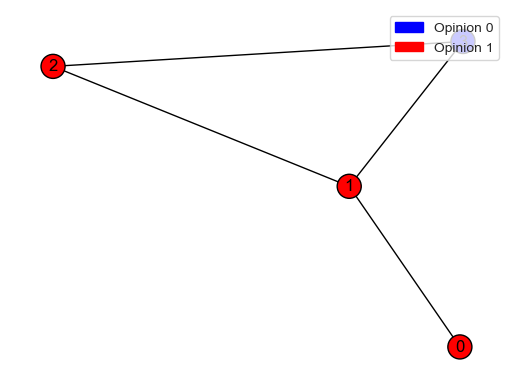

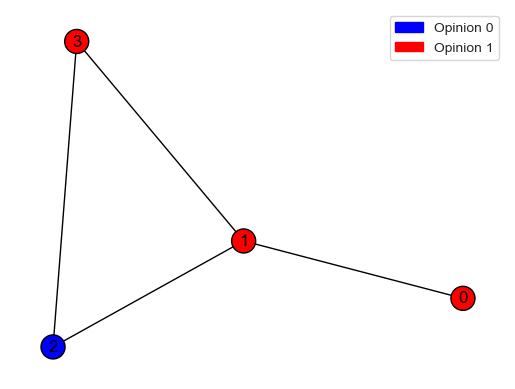

In [56]:
def reactive_cond_i_calc(forward_committors, backward_committors):
    cond_prob = forward_committors * backward_committors
    return cond_prob

reactive_cond_i = reactive_cond_i_calc(q_plus, q_minus)

for t in range(N):
    visualise_graph_state(np.argmax(reactive_cond_i[t]), size, G)
    plt.show()

In [138]:
from tpt_gc import cprob_current_calculator

def cprob_current_calculator(q_plus, q_minus, P):
    N = len(q_plus) - 1
    size = len(P)
    
    prob_current_matrix = np.zeros((N, size, size)) # Initialise the probability current matrix
    
    for n in range(N):
        prob_current_matrix[n] =  q_minus[n].reshape((size,1)) * P * q_plus[n+1]
    
    return prob_current_matrix
    
cprob_current = cprob_current_calculator(q_plus, q_minus, P)

## <a id='CPII'> <font color='blue'> __Conditional Probability II__ </a>
Suppose we are currenttly at a state $i$. Given that we are reactive, where are we most likely to go next?
This question can be answered fairly easily in the case $i \notin A \cup B$ - the quantity we are interested in is 
\begin{align}
&  \mathbb{P}(X_{n+1} = j | X_n = i, ,\tau_A^-(n) > \tau_B^-(n), \,  \tau_{A}^+(n) > \tau_B^+(n))\\ 
& =  \frac{\mathbb{P}(X_{n+1} = j, \, X_n = i, ,\tau_A^-(n) > \tau_B^-(n), \,  \tau_{A}^+(n) > \tau_B^+(n))}{{\mu}_i(n)} ,
\end{align}

but since $i \notin A \cup B$, we have that $\tau_A^+(n) = \tau_A^+(n + 1) $ and $\tau_B^+(n) = \tau_B^+(n + 1) $, which means that the probability in the numerator is precisely $F_{ij}(n)$. Thus we may write it as 

$$\frac{F_{ij} (n)}{\mu_i (n)}.$$


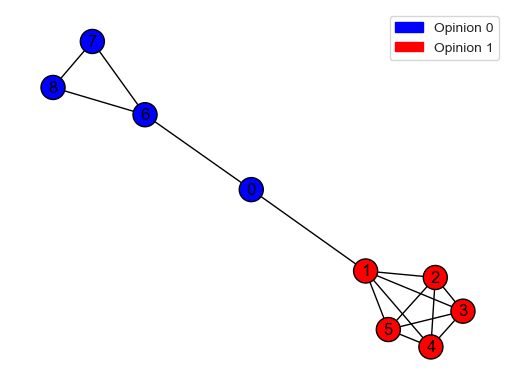

[False False False  True  True  True  True  True  True]


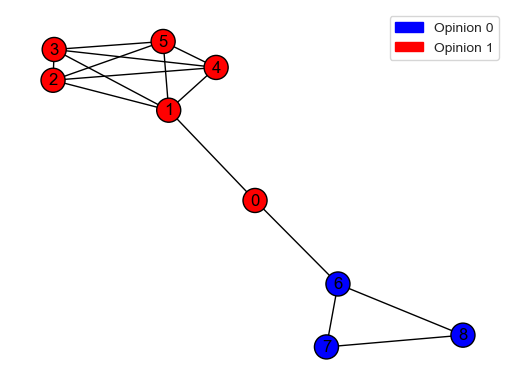

[False False False  True  True  True  True  True  True]


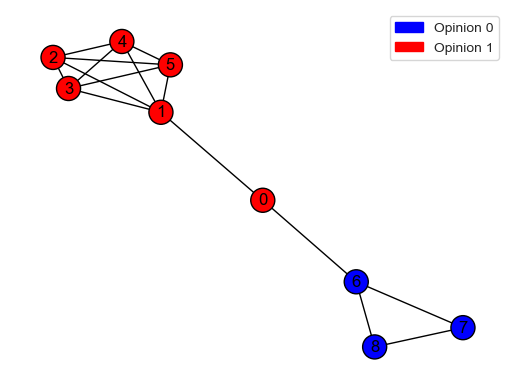

[False False False  True  True  True  True  True  True]


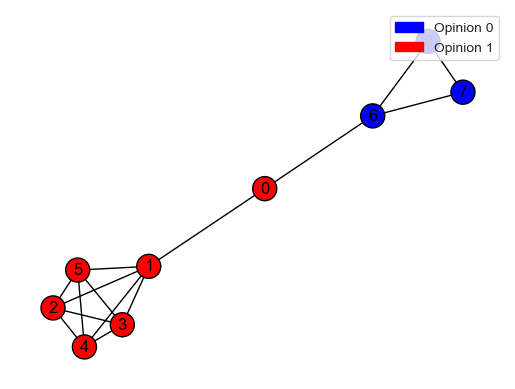

[False False False  True  True  True  True  True  True]


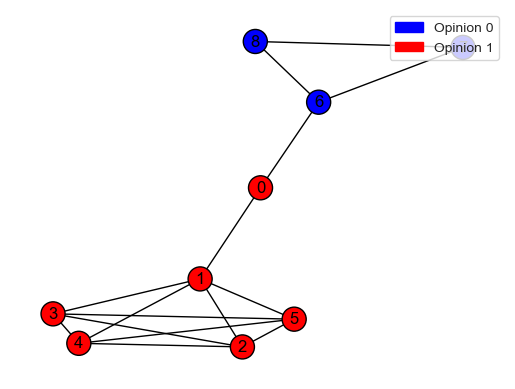

[False False False  True  True  True  True  True  True]


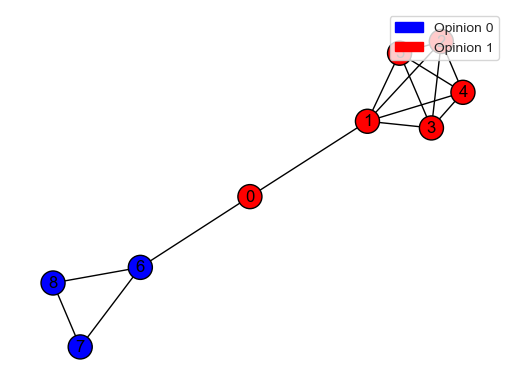

[False False False  True  True  True  True  True  True]


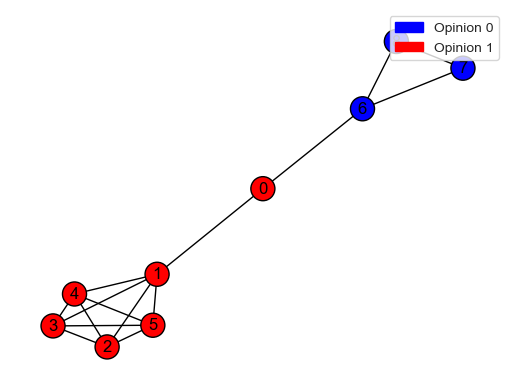

[False False False  True  True  True  True  True  True]


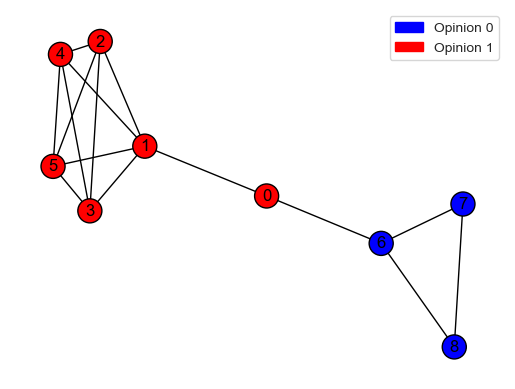

[False False False  True  True  True  True  True  True]


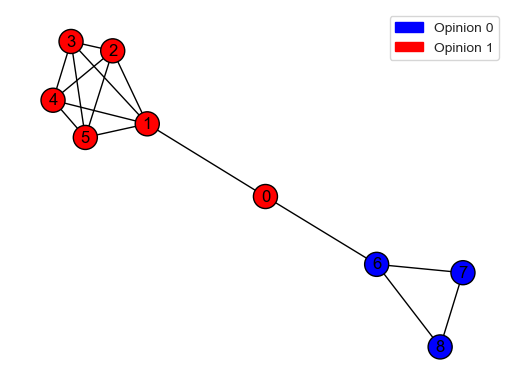

[False False False  True  True  True  True  True  True]


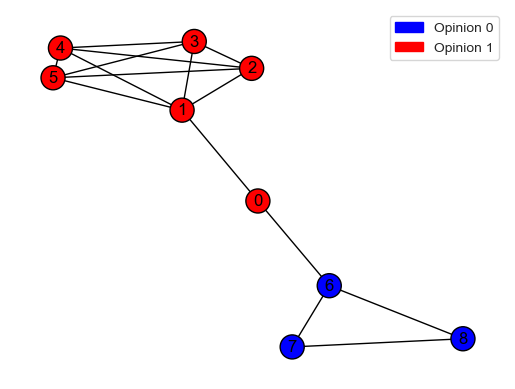

[False False False  True  True  True  True  True  True]


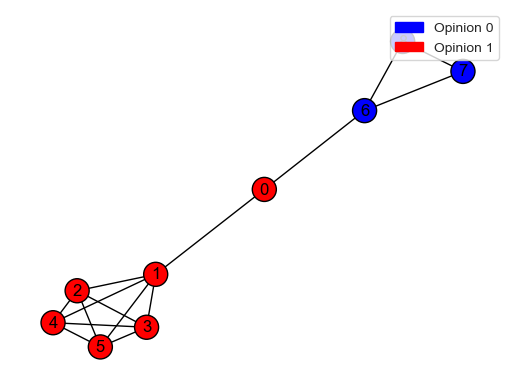

[False False False  True  True  True  True  True  True]


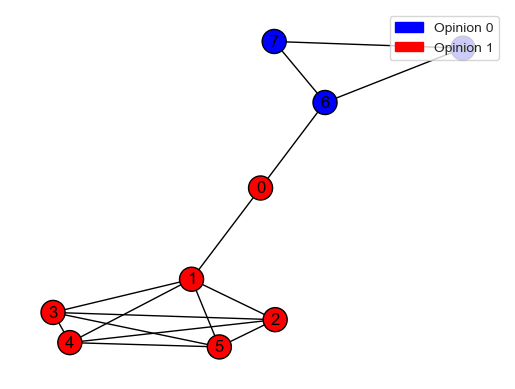

[False False False  True  True  True  True  True  True]


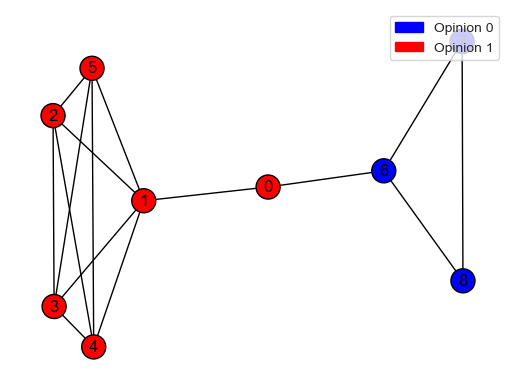

[False False False  True  True  True  True  True  True]


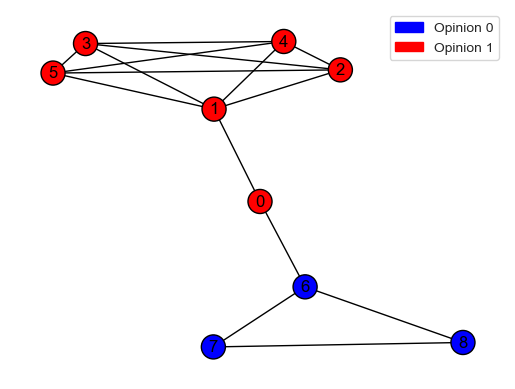

[False False False  True  True  True  True  True  True]


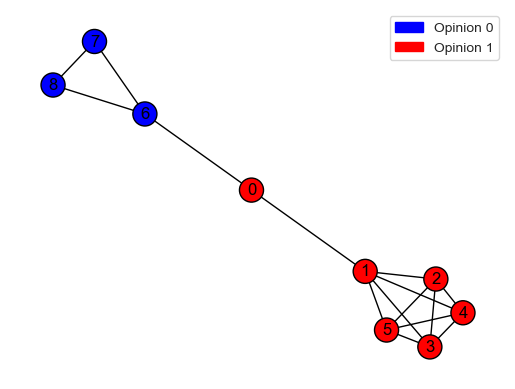

[False False False  True  True  True  True  True  True]


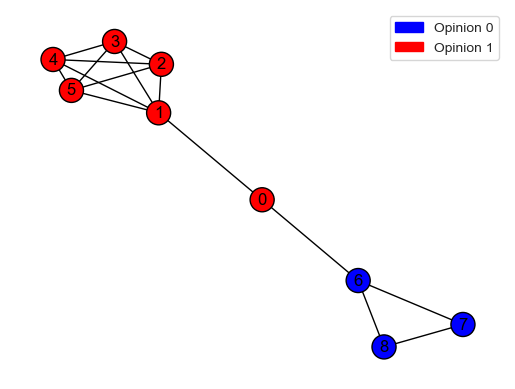

[False False False  True  True  True  True  True  True]


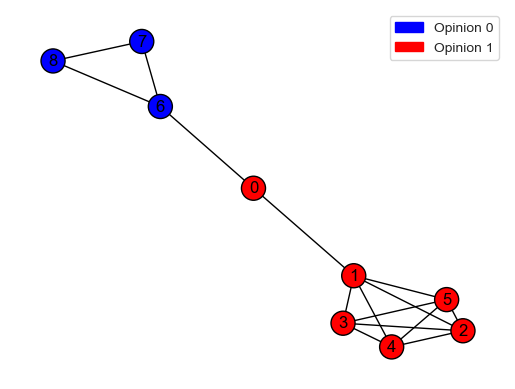

[False False False  True  True  True  True  True  True]


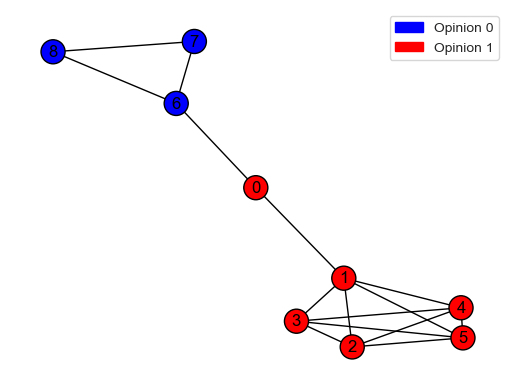

[False False False  True  True  True  True  True  True]


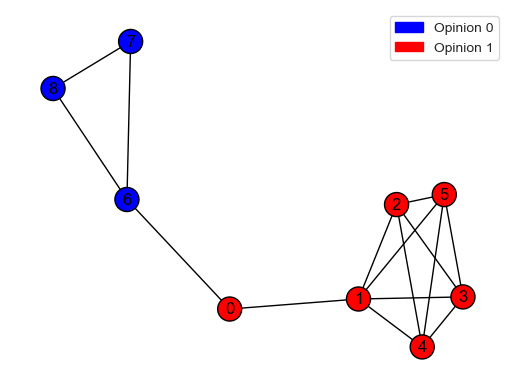

[False False False  True  True  True  True  True  True]


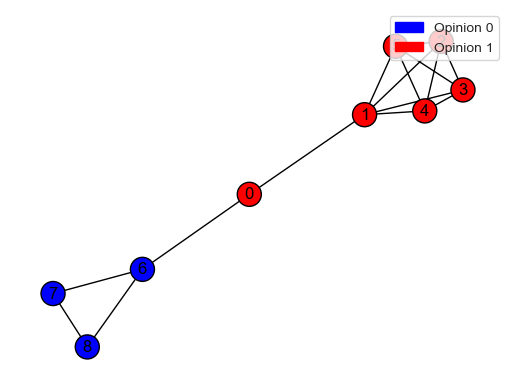

[False False False  True  True  True  True  True  True]


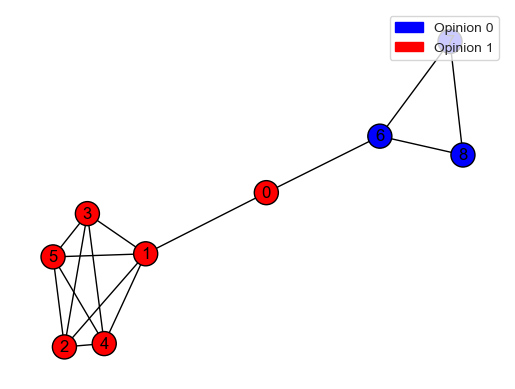

[False False False  True  True  True  True  True  True]


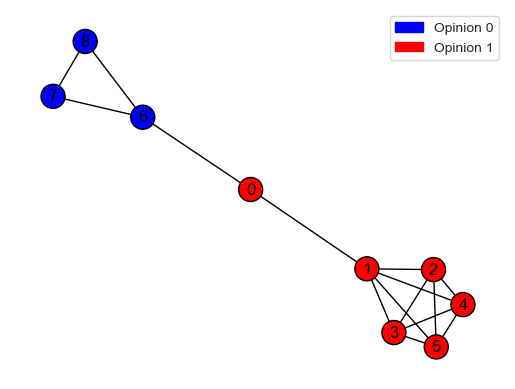

[False False False  True  True  True  True  True  True]


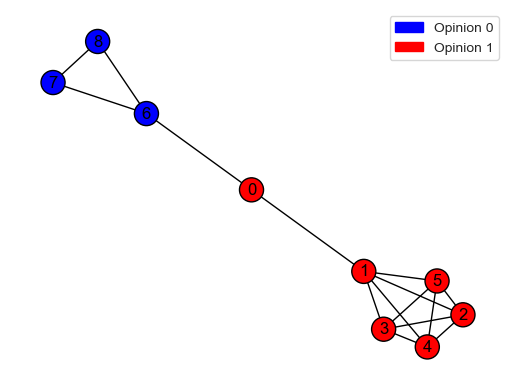

[False False False  True  True  True  True  True  True]


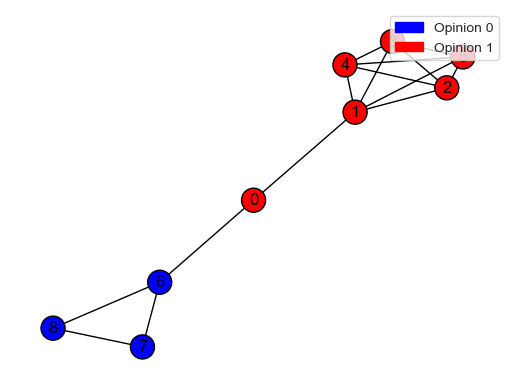

[False False False  True  True  True  True  True  True]


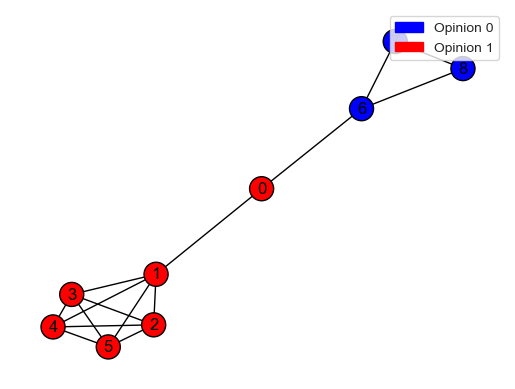

[False False False  True  True  True  True  True  True]


In [154]:
prob_current

def high_reactivity_tracker(ics, cprob_current, T_1=0):
    for t in range(T_1, N):
        if t == T_1:
            moving_node = ics
        if moving_node in B:
            break
        visualise_graph_state(moving_node, n, G)
        moving_node = np.argmax(prob_current[n, moving_node])
        print(base10_to_binary(moving_node, n))
        #visualise_graph_state(moving_node, n, G)
        
    return

high_reactivity_tracker(binary_to_base10(np.array([0,0,0,1,1,1,1,1,0]), n), prob_current, )

In [58]:
def reactive_cond(reactive_distributions, prob_current, n, i, A, B):
    if i in A or i in B:
        print("Invalid input - Please choose an i not in A or B.")
        return
        
    reactive_prob_i = reactive_distributions[n, i]         
    return base10_to_binary(np.argmax(prob_current[n, i] / reactive_prob_i), size) * 1, np.max(prob_current[n, i] / reactive_prob_i)

reactive_cond(reactive_distributions, prob_current, 15, binary_to_base10(np.array([0,0,0,0,0,0,0,0,0]), size), A, B)

(array([0, 0, 0, 0]), 0.6468547500583937)

## <a id ='ExpOpi'> <font color = 'blue'> __Expected Mean Reactive Opinion__ </a>
For a state $v = (v_1, v_2, \cdots, v_n) \in \{0, 1\}^n$, we may define the _mean opinion_:
$$ M_v = \frac{\sum_{i}v_i}{n}$$
And then define the _expected mean opinion_, conditioned on being reactive
$$\sum_{v \in S} M_v \rho_v^{A \rightarrow B}(n)$$

In [70]:
# Creating an array with the mean opinion of each state

def number_to_mean_opinion(number):
    opinion = (base10_to_binary(number, size).sum()) / size
    return opinion

number_to_mean_opinion = np.frompyfunc(number_to_mean_opinion, 1, 1)
mean_opinion = number_to_mean_opinion(np.arange(2 ** size))

cexpected_mean_opinion = np.sum( (mean_opinion * cond_reactive_distributions), axis=1)
expected_mean_opinion = np.sum( (mean_opinion * distributions), axis=1)

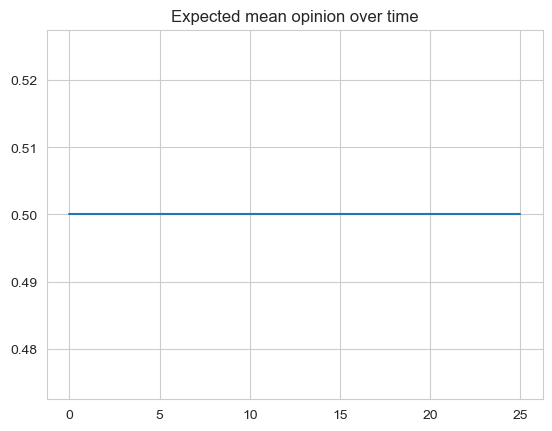

In [72]:
plt.plot(expected_mean_opinion)
plt.title('Expected mean opinion over time')
plt.show()

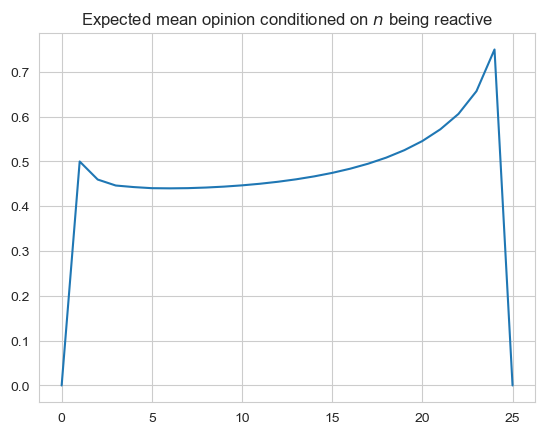

In [74]:
plt.plot(cexpected_mean_opinion)
plt.title(r'Expected mean opinion conditioned on $n$ being reactive')
plt.show()

## <a id='SPath'> <font color = 'blue'> __Bottleneck__ </a>
This section follows the characterisation of bottlenecks by Metzner (2009). 

In [87]:
def eff_curr_calc(prob_curr): # Calculation of effective current
    eff_curr = np.zeros(prob_curr.shape)
    for n in range(len(prob_curr)): # indexing over time
        eff_curr[n] = np.where((prob_curr[n] - prob_curr[n].T) > 0, (prob_curr[n] - prob_curr[n].T), 0)

    return eff_curr

eff_curr = eff_curr_calc(prob_current)
